# 参考

词料来源：https://github.com/chinese-poetry/chinese-poetry

将其保存到本地目录

*** keras 实现：***

** 参考一：**
        https://github.com/youyuge34/Poems_generator_Keras

        训练，以前6个字符预测第七个字符。 其功能如藏头诗等，也是基于此来做的。
        数据细节：没有考虑逗号",";

** 参考二 **
        https://github.com/Clover27/ancient-Chinese-poem-generator

        训练，以前6个字符预测第七个字符。
        数据细节：没有考虑逗号","; 直接用前6个字判断第七个字。

** 参考三 ** 
        https://github.com/jinfagang/tensorflow_poems
        tensorflow实现; 采用pixelRNN。
        数据细节：没有考虑逗号","


** pixelRNN **参考：
        https://chunml.github.io/ChunML.github.io/project/Creating-Text-Generator-Using-Recurrent-Neural-Network/  
        
        可实现
** language model **
参考：https://machinelearningmastery.com/develop-word-based-neural-language-models-python-keras/
https://machinelearningmastery.com/develop-character-based-neural-language-model-keras/
        

In [2]:
from __future__ import print_function

# sys import
import collections
import os
import sys
import time

# math
import copy
from random import randint
import re
import json
import numpy as np
import  matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import fmin_l_bfgs_b

# keras
import keras
from keras import backend as K
from keras.models import load_model, Sequential,Model
from keras.preprocessing import image as kimage
from keras.layers import Input, Dense, Dropout, Flatten,Reshape, TimeDistributed,LSTM
from keras.layers.core import Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.mobilenet import MobileNet
#from keras.preprocessing.image import img_to_array

import tensorflow as tf

Using TensorFlow backend.


# 查看数据

In [125]:
file_name = 'poems.txt'
max_len = 0
miss = 0 
total = 0 
with open(file_name, "r", encoding='utf-8', ) as f:
    for line in f.readlines():
        try:
            title, content = line.strip().split(':')
            content = content.replace(' ', '')
            #if '_' in content or '(' in content or '（' in content or '《' in content or '[' in content :
            #    continue
            #print(re.split('[+]',content))
            #break
            tm = max(len(p) for p in re.split('[+]',content))
            max_len = tm if tm>max_len else max_len
            if tm>25:
                miss +=1
                #print(line)
                #print(re.split('[+]',content))
                #break
            total += 1
        except:
            continue
print(max_len,miss,total)

76 226 43028


# 失败的模型

每个句子，为一个样本： 输入为一个句子，输出为错位的一个句子。 

训练出来的模型(30个echo)得到的结果不太对：无论输入词是什么，下一词概率最大的仍为同一个词。

** 原因：** 

一是由于样本只有29万左右的句子，样本量太少了。

二是时间步长为25，对于只有29万的文本量来说，有点太长了。


## 处理数据

In [145]:
SEQ_LEN = 25 # 也是timestep的长度

In [4]:
# 不可使用 以一句话作为一个训练样本
def process_poems_v1(file_name):
    contents = ''
    sentence_set = []
    with open(file_name, "r", encoding='utf-8', ) as f:
        for line in f.readlines():
            try:
                title, content = line.strip().split(':')
                contents += content  

                content = content.replace(' ', '')
                cont_list = re.split('[+]',content) # 以+为断句。
                
                if cont_list[-1] != '': #最后一个sentence应该为空
                    cont_list = cont_list[:-1] 

                for sen in cont_list :
                    if len(sen) > SEQ_LEN:
                        continue
                    sentence_set.append(sen)

            except ValueError as e:
                pass
    
    all_words = list(contents)

    #vocabs = set(all_words)  # 不可用
    counter = collections.Counter(all_words)
    vocabs = tuple([_[0] for _ in counter.items()])

    vocabs = vocabs[:len(vocabs)] + (' ',)  #字典  
    int_word_map = {ix:word for ix, word in enumerate(vocabs)}
    word_int_map = {word:ix for ix, word in enumerate(vocabs)}
    
    sentence_vec = [list(map(lambda word: word_int_map.get(word, len(vocabs)), sen)) for sen in sentence_set]

    return sentence_vec, word_int_map, int_word_map, vocabs

## 构造训练数据

In [13]:
sentence_vec, word_int_map, int_word_map, vocabs = process_poems_v1('poems.txt')

In [14]:
HIDDEN_DIM = 50
VOCAB_SIZE = len(vocabs)
LAYER_NUM = 2
SENTENCE_NUM = len(sentence_vec)

In [8]:
# 不能跑！，占的内存很大，程序会挂掉
def get_train_data_v1(sentence_vec, word_int_map, vocabs):
    VOCAB_SIZE = len(vocabs)
    SENTENTCE_NUM = len(sentence_vec)
    
    X = np.zeros((SENTENTCE_NUM, SEQ_LEN, VOCAB_SIZE))
    y = np.zeros((SENTENTCE_NUM, SEQ_LEN, VOCAB_SIZE))
    
    for ix in range(SENTENTCE_NUM):       
        input_seq = sentence_vec[ix]
        input_seq += (SEQ_LEN-len(input_seq))* [word_int_map[' ']] # 补充到25的长度
        input_seq_onehot = np.zeros((SEQ_LEN, VOCAB_SIZE))
        for j in range(SEQ_LEN):
            input_seq_onehot[j][input_seq[j]] = 1
            
        X[ix] = input_seq_onehot
        
        output_seq_onehot = copy.copy(input_seq_onehot)
        output_seq_onehot[:,:-1] = output_seq_onehot[:,1:] 
        
        y[ix] = output_seq_onehot
        
    return X,y

In [7]:
# 使用迭代器
def train_data_generator_v1(sentence_vec, word_int_map, vocabs, batch_size):
    VOCAB_SIZE = len(vocabs)
    while True:     
        X = np.zeros((batch_size, SEQ_LEN, VOCAB_SIZE))
        y = np.zeros((batch_size, SEQ_LEN, VOCAB_SIZE))
        for bn in range(batch_size):
            ix = randint(0, len(sentence_vec)-1) #随机取一个
            input_seq = sentence_vec[ix]
            input_seq += (SEQ_LEN-len(input_seq))* [word_int_map[' ']] # 补充到25的长度
            input_seq_onehot = np.zeros((SEQ_LEN, VOCAB_SIZE))
            for j in range(SEQ_LEN):
                input_seq_onehot[j][input_seq[j]] = 1
        
            output_seq_onehot = copy.copy(input_seq_onehot)
            output_seq_onehot[:,:-1] = output_seq_onehot[:,1:]
            
            X[bn] = input_seq_onehot
            y[bn] = output_seq_onehot
        yield (X,y)

## 训练模型

In [25]:
model = Sequential()
model.add(LSTM(HIDDEN_DIM, input_shape=(SEQ_LEN, VOCAB_SIZE), return_sequences=True))
model.add(Dropout(0.8))
model.add(LSTM(HIDDEN_DIM, return_sequences=True))
model.add(Dropout(0.8))
model.add(TimeDistributed(Dense(VOCAB_SIZE)))
model.add(Activation('softmax'))
model.compile(loss="categorical_crossentropy", optimizer="rmsprop")

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25, 50)            1520000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 25, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 50)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 25, 7549)          384999    
_________________________________________________________________
activation_1 (Activation)    (None, 25, 7549)          0         
Total params: 1,925,199
Trainable params: 1,925,199
Non-trainable params: 0
_________________________________________________________________


In [35]:
# 回调函数
# 训练过程可视化
tb = keras.callbacks.TensorBoard(log_dir='./logs')

# 保存训练的模型
ckpoint = keras.callbacks.ModelCheckpoint('models/models.{epoch:02d}.hdf5')

callbacks = [tb, ckpoint]

In [ ]:
# 多次训练，得到30个echo
history = model.fit_generator(generator=train_data_generator(sentence_vec, word_int_map, vocabs,32),
                    steps_per_epoch=SENTENCE_NUM//32, epochs=20,
                    callbacks=callbacks)

Epoch 1/10
  13/8493 [..............................] - ETA: 1:19:22 - loss: 3.1073

## 生成数据

In [148]:
def get_next_prediction(preds):
    while True: 
        # 方式一：取最大概率的; 但是这样的话产出的诗是固定的。
        #ix = np.argmax(preds) 
        #break

        ps = preds.argsort()[-10:][::-1]
        #print(ps)
        for ix in ps:
            if (ix != word_int_map[u' ']) and (ix != word_int_map['-']) and (ix != word_int_map['+']):
                #print(ix)
                return ix
            
        
        # 方式二：#按照概率取下一个词
        #ix = np.random.choice(VOCAB_SIZE, p=preds) 
        if ix != word_int_map[' ']:
            break
    return ix

def generate_poem(model, first_word): #五言绝句
    
    poetry = ''#copy.copy(first_word)
    
    X = np.zeros((1, SEQ_LEN, VOCAB_SIZE))
    ix = word_int_map.get(first_word,None)
    
    if ix is None:
        ix = randint(0, len(VOCAB_SIZE)-1) #随机取一个作为first_word的ix
        
    for i in range(24): #预测多次

        if i in [5,11,17,23]: #使用标点符号
            char = '-' if (i in [5,11]) else '+'
            poetry += char
            #print('fuck',i,ix,int_word_map[ix],poetry)

            # 下一个位置，各个词出现的概率
            X[0][i][word_int_map[char]] = 1
            preds = model.predict(X)[0][i]  
            ix = get_next_prediction(preds)
            continue
        
        poetry += int_word_map[ix]
        #print(ix,int_word_map[ix],poetry)
        
        # 下一个位置，各个词出现的概率
        X[0][i][ix] = 1
        preds = model.predict(X)[0][i] 

        ix = get_next_prediction(preds)
        #if i==1 :
        #    return preds
    
    poetry = poetry.replace('-',u'，')
    poetry = poetry.replace('+',u'。')
    return poetry 

In [149]:
# 用第二十个echo训练出来的模型，做验证
demo_model = load_model('models_30/models.10.hdf5')
print(generate_poem(demo_model, '锄')) #用训练的模型
print(generate_poem(demo_model, '晚')) #用训练的模型

锄鰅骊蜊鰅，鰅骊蜊鰅骊，鰅骊蜊鰅骊。扳鰅骊蜊鰅。
晚鰅骊蜊鰅，鰅骊蜊鰅骊，鰅骊蜊鰅骊。扳鰅骊蜊鰅。


In [151]:
print(generate_poem(demo_model, '云')) #用训练的模型
print(generate_poem(demo_model, '春')) #用训练的模型

云鰅骊蜊鰅，鰅骊蜊鰅骊，鰅骊蜊鰅骊。扳鰅骊蜊鰅。
春鰅骊蜊鰅，鰅骊蜊鰅骊，鰅骊蜊鰅骊。扳鰅骊蜊鰅。


In [23]:
# 用第十一个echo训练出来的模型，做验证
#demo_model = load_model('models_20/models.01.hdf5')
print(generate_poem(demo_model, '锄')) #用训练的模型
print(generate_poem(demo_model, '晚')) #用训练的模型

锄鰅鰅鰅鰅，鰅鰅鰅鰅鰅，鰅鰅鰅鰅鰅。鰅鰅鰅鰅鰅。
晚鰅鰅鰅鰅，鰅鰅鰅鰅鰅，鰅鰅鰅鰅鰅。鰅鰅鰅鰅鰅。


# 模型二

## 处理数据

In [219]:
SEQ_LEN = 5 # 也是timestep的长度

In [47]:
def process_poems_v2(file_name):
    # 诗集
    contents = ''
    sentence_set = []
    with open(file_name, "r", encoding='utf-8', ) as f:
        for line in f.readlines():
            try:
                title, content = line.strip().split(':')
                contents += content  

                content = content.replace(' ', '')
                cont_list = re.split('[+]',content) # 以+为断句。
                
                if cont_list[-1] != '': #最后一个sentence应该为空
                    cont_list = cont_list[:-1] 
                    
                clean_content = '+'.join(cont_list)
                
                sentence_set.append(clean_content)
                
            except ValueError as e:
                pass
    
    all_words = list(contents)

    #vocabs = set(all_words)  # 不可用
    counter = collections.Counter(all_words)
    vocabs = tuple([_[0] for _ in counter.items()])

    vocabs = vocabs[:len(vocabs)] + (' ',)  #字典  
    int_word_map = {ix:word for ix, word in enumerate(vocabs)}
    word_int_map = {word:ix for ix, word in enumerate(vocabs)}
    
    sentence_vec = [list(map(lambda word: word_int_map.get(word, len(vocabs)), sen)) for sen in sentence_set]

    return sentence_vec, word_int_map, int_word_map, vocabs

## 构造训练数据

In [56]:
sentence_vec, word_int_map, int_word_map, vocabs = process_poems_v2('poems.txt')

In [75]:
HIDDEN_DIM = 50
VOCAB_SIZE = len(vocabs)
LAYER_NUM = 2
SENTENCE_NUM = len(sentence_vec)

In [72]:
# 使用迭代器
def train_data_generator_v2(sentence_vec, word_int_map, vocabs, batch_size):
    VOCAB_SIZE = len(vocabs)
    while True:     
        X = np.zeros((batch_size, SEQ_LEN, VOCAB_SIZE))
        y = np.zeros((batch_size, SEQ_LEN, VOCAB_SIZE))
        
        bn = 0
        while bn < batch_size:
        #for bn in range(batch_size):
            ix = randint(0, len(sentence_vec)-1) #随机取一个
            one_sen = sentence_vec[ix]
            
            for ib in range(0,len(one_sen)-SEQ_LEN,2):
                input_seq = one_sen[ib : ib+SEQ_LEN]
                output_seq = one_sen[ib+1: ib+SEQ_LEN+1]
                
                input_seq_onehot = np.zeros((SEQ_LEN, VOCAB_SIZE))
                output_seq_onehot = np.zeros((SEQ_LEN, VOCAB_SIZE))

                for j in range(SEQ_LEN):
                    input_seq_onehot[j][input_seq[j]] = 1
                    output_seq_onehot[j][output_seq[j]] = 1
                
                X[bn] = input_seq_onehot
                y[bn] = output_seq_onehot
                bn += 1
                if bn >= batch_size:
                    break
            
        yield (X,y)

## 测试-构造训练数据

In [73]:
a = train_data_generator_v2(sentence_vec, word_int_map, vocabs,32)

In [74]:
g = None
for x in a:
    g=x[0]
    print(len(x[0]),len(x[1]),x[0].shape)
    break

32 32 (32, 5, 7549)


## 训练model
参考Poems_generator_Keras,不过把模型由 multi-2-one 变为multi-2-multi。 

In [76]:
model = Sequential()
model.add(LSTM(512, input_shape=(SEQ_LEN, VOCAB_SIZE), return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(216, return_sequences=True))
model.add(Dropout(0.6))
model.add(TimeDistributed(Dense(VOCAB_SIZE)))
model.add(Activation('softmax'))
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [216]:
# 回调函数
# 训练过程可视化
tb = keras.callbacks.TensorBoard(log_dir='./logs')

# 保存训练的模型
ckpoint = keras.callbacks.ModelCheckpoint('models_20/models.{epoch:02d}.hdf5')

callbacks = [tb, ckpoint]

In [ ]:
history20 = model.fit_generator(generator=train_data_generator_v2(sentence_vec, word_int_map, vocabs,32),
                    steps_per_epoch=10000, epochs=10,
                    callbacks=callbacks)

Epoch 1/10
  413/10000 [>.............................] - ETA: 51:32 - loss: 5.3541

## 生成数据

In [220]:
def get_next_prediction(preds):
    bad_word_ind = [word_int_map[u' '], word_int_map['-'], word_int_map['+']]
    """
    # 方式一：取最大概率的; 但是这样的话产出的诗是固定的。
    ps = preds.argsort()[-20:][::-1]
    for ix in ps:
        if ix not in bad_word_ind:
            return ix
    """
    # 方式二：#按照概率取下一个词
    ps = preds.argsort()[-20:][::-1]
    ps = [_ for _ in ps if _ not in bad_word_ind]
    pre = np.array([preds[_] for _ in ps if _ not in bad_word_ind])
    pre = pre/pre.sum()
    ix = np.random.choice(ps, p=pre) 
    return ix

def predict_sentence(model,first_word):
    ''' 产出一个句子'''
    poetry = ''#copy.copy(first_word)
    X = np.zeros((1, SEQ_LEN, VOCAB_SIZE))
    ix = word_int_map.get(first_word,None)
    
    if ix is None:
        ix = randint(0, len(VOCAB_SIZE)-1) #随机取一个作为first_word的ix
        
    for i in range(5): #预测多次     
        poetry += int_word_map[ix]
        
        # 此位置的输出，也就是下一个位置的各个词出现的概率
        X[0][i][ix] = 1
        preds = model.predict(X)[0][i]
        ix = get_next_prediction(preds)
    return poetry 

def generate_poem(model, first_word): 
    """ 五言绝句 """
    poetry = ''#copy.copy(first_word)
    # 五言绝句，共24个词
    X = np.zeros((1,24 , VOCAB_SIZE))
    ix = word_int_map.get(first_word,None)
    
    if ix is None:
        ix = randint(0, len(VOCAB_SIZE)-1) #随机取一个作为first_word的ix
        
    for i in range(24): #预测多次
        pred_x = np.zeros((1,SEQ_LEN , VOCAB_SIZE))
        if i in [5,11,17,23]: #使用标点符号
            char = '-' if (i in [5,17]) else '+'
            poetry += char
            #print('fuck',i,ix,int_word_map[ix],poetry)

            # 此位置的输出，也就是下一个位置的各个词出现的概率
            X[0][i][word_int_map[char]] = 1
            pred_x[0] = X[0][:5] if i<5 else X[0][i-5:i]

            #print(model.predict(X[end_ind-5,end_ind])[0].shape)
            preds = model.predict(pred_x)[0][4]  
            ix = get_next_prediction(preds)
            continue
        
        poetry += int_word_map[ix]
        #print(ix,int_word_map[ix],poetry)
        
        X[0][i][ix] = 1
        pred_x[0] = X[0][:5] if i<5 else X[0][i-5:i]
        get_i = i if i < 5 else 4 
        # 预测此位置的输出，也就是下一个位置的各个词出现的概率
        preds = model.predict(pred_x)[0][get_i]
        ix = get_next_prediction(preds)
    
    poetry = poetry.replace('-',u'，')
    poetry = poetry.replace('+',u'。')
    return poetry 


In [156]:
# 用第十个echo训练出来的模型，做验证
demo_model = load_model('models/models.10.hdf5')

In [211]:
# 生成五言绝句,训练了10个echo的模型
print(predict_sentence(demo_model, '锄'))
print(predict_sentence(demo_model, '晚')) 
print(predict_sentence(demo_model, '云'))
print(predict_sentence(demo_model, '马'))
print(predict_sentence(demo_model, '书'))

锄来未可寻
晚雨生花雪
云生石石山
马自还王署
书剑一来人


In [210]:
# 生成五言绝句,训练了10个echo的模型
print(generate_poem(demo_model, '锄')) 
print(generate_poem(demo_model, '晚'))
print(generate_poem(demo_model, '云'))
print(generate_poem(demo_model, '马'))
print(generate_poem(demo_model, '书'))

锄人事长安，未不尽有如。何莫时归来，后谁山来客。
晚来来几年，风何起处处。人谁间知在，山不水入平。
云外入空空，不万是金长。一不叶成边，不春见人故。
马蹄来不得，无何劳人者。如不何为用，一神生无在。
书为有所见，长此为时君。自一道千士，已如向一海。


In [221]:
# 第二十个echo模型
demo_model = load_model('models_20/models.10.hdf5')

In [222]:
# 生成五言绝句,训练了20个echo的模型
print(generate_poem(demo_model, '锄')) 
print(generate_poem(demo_model, '晚'))
print(generate_poem(demo_model, '云'))
print(generate_poem(demo_model, '马'))
print(generate_poem(demo_model, '书'))

锄尽青山在，石何室时中。有我事相人，已一向年秋。
晚光生不极，来一往一来。来不年见还，难何随一我。
云外远烟春，欲月与花春。未夜有归时，未日必天相。
马嘶青草远，无一限片离。时谁节识相，寻金常得自。
书不足如今，不自知得身。难我为有游，兮一天其涯。


In [223]:
# 生成五言绝句,训练了20个echo的模型
print(predict_sentence(demo_model, '锄'))
print(predict_sentence(demo_model, '晚')) 
print(predict_sentence(demo_model, '云'))
print(predict_sentence(demo_model, '马'))
print(predict_sentence(demo_model, '书'))

锄来有人去
晚风吹竹竹
云水在西南
马蹄归不足
书书入故人


## 训练过程loss 画图

In [212]:
history.history['loss']

[6.1911234814643858,
 5.8134521771430974,
 5.6579700903892514,
 5.566398260450363,
 5.482896227884293,
 5.4445278005599977,
 5.4105356895446777,
 5.3697276246547698,
 5.3470917725324627,
 5.3215426424980166]

In [30]:
import matplotlib.pyplot as plt

In [214]:
%matplotlib inline

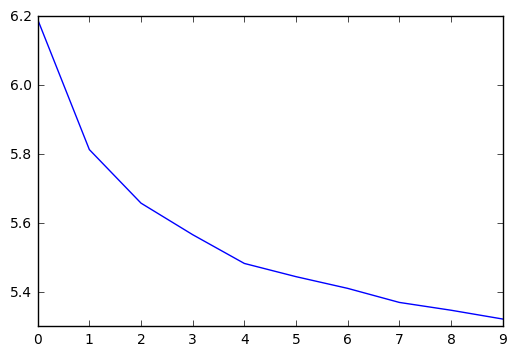

In [215]:
# 前十个echo训练出来的loss
plt.plot(history.history['loss'])

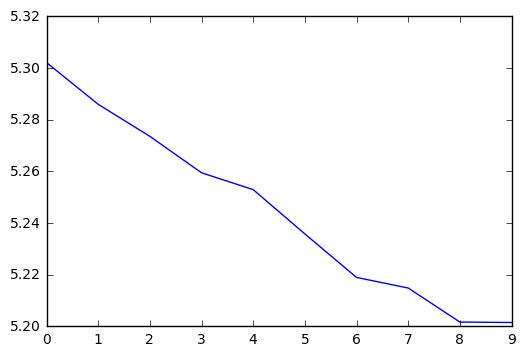

In [225]:
# 前十个echo训练出来的loss
plt.plot(history20.history['loss'])

In [226]:
echo_20_loss = history.history['loss']
echo_20_loss += history20.history['loss']

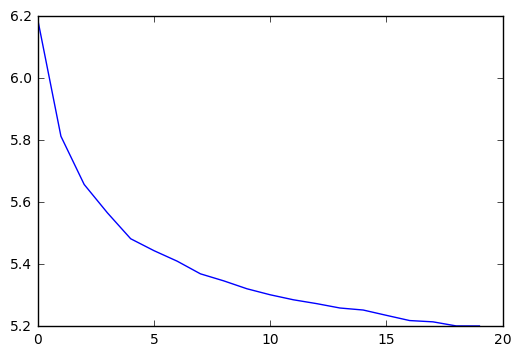

In [227]:
plt.plot(echo_20_loss)